# CS549-02 Machine Learning - Irfan Khan
# Assignment 5: <br>EigenHand -- An application of principal component analysis (PCA) on image processing

Updated from assignment designed by Yang Xu, Ex-Assistant Professor of Computer Science, San Diego State University

**Total points: 10**

In this assignment, you will implement principal component analysis (PCA) using numpy, and conduct some experiments that are similar to the "EigenFace" study introduced in the class. 

We use the sign language image data. What we are basically doing is to select the image data of one class (e.g., the sign for "zero"), and extract its principal components (PCs). Then we can visualize the data by reducing the dimension to the first 2 most dominant PCs. Also, given a new image, we can use its projections onto the PCs to determine whether it is a sign for "zero" or not.

In [3]:
import numpy as np
import matplotlib.pyplot as plt



### Load data

Load data and preprocess. We are taking a subset of the data from X_train.npy and Y_train.npy and storing in X and Y. Specifically we will work with sign-language samples indicating 0. There are 163 such samples starting from the beginning of the dataset. 10 bits are used to represent the sample output. Specifically 0 is represented by [1.,0.,0.,0.,0.,0.,0.,0.,0.,0.].

The dimension of data in X_train.npy is $m\times n$, in which $n=4096=64\times64$ is the total number of pixels in an image, and $m=163$ is the number of examples.

Here we create a numpy array $X$ containing the 163 sign language images for 0.

(1644, 64, 64, 1)
(1644, 10)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
X shape: (163, 4096)


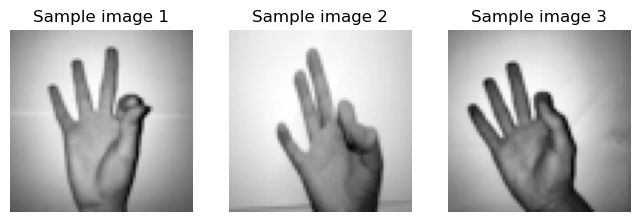

In [4]:
X_all = np.load(open('X_train.npy', 'rb'))
Y_all = np.load(open('Y_train.npy', 'rb'))
print(X_all.shape)
print(Y_all.shape)
print(Y_all[0,]) # y=0
print(Y_all[1,]) # y=0
print(Y_all[2,]) # y=0
print(Y_all[162,]) # y=0
print(Y_all[163,]) # y=1
print(Y_all[327,]) # y=2
print(Y_all[491,]) # y=3

# Extract the first 163 rows and remove the last dimension

X = X_all[:163, :, :, 0]

# Flatten the 2nd and 3rd dimensions into a single column
X = X.reshape(163, -1)

print('X shape:', X.shape)

# Print some sample images
fig = plt.figure(figsize=(8, 4))
for i, idx in enumerate([0, 50, 100]):
#for i,idx in enumerate ([164,50,264]):
    fig.add_subplot(1, 3, i+1)
    img = X_all[idx,:,:,0]
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Sample image {}'.format(i+1))
plt.show()


## Task 1 Centerize data
**1 points**

We need to centerize the data by subtracting $X$ from the mean values of each column. I.e., for each $i,j$, $X[i,j]=X[i,j]-mean(X[,:j])$.

This step is necessary before carrying out PCA. You may notice that in the slides we do a further normalization by dividing by the standard deviation after subtracting the means. In this homework, we do not use the divding step for the convenience of later reconstruction steps. Fortunately, not fullly normalizing the data will not harm PCA of image data.

**Instructions:**
- You can use `np.mean()` to compute the mean of each row, with argument `axis=0`. Pay attention to the dimensions of each matrix

In [5]:
# Complete the code and run it to evaluate

### START YOUR CODE ###
# Calculate mean for each column
Xtilde = X - np.mean(X, axis=0)

# Subtract mean of the column from each entry of X in that column. Store in Xtilde



### END YOUR CODE ###

print ('Shape of centerized data',Xtilde.shape)
print('First 5 elements of the first column in X_tilde:', Xtilde[:5,0])
print('First 5 elements of the last column in X_tilde:', Xtilde[:5,-1])


Shape of centerized data (163, 4096)
First 5 elements of the first column in X_tilde: [-0.01975209 -0.01583052  0.2939734   0.32534593 -0.0432815 ]
First 5 elements of the last column in X_tilde: [-0.06082091  0.01761046  0.08427715  0.23329675  0.00192419]


### Expected output


**Shape of the centerized data:** (163, 4096)<br>
**First 5 elements of first column in X_tilde:** [-0.01975209 -0.01583052  0.2939734   0.32534593 -0.0432815 ]<br>
**First 5 elements of last column in X_tilde:** [-0.06082091  0.01761046  0.08427715  0.23329675  0.00192419]

***

## Task 2. Construct covariance matrix and compute eigenvectors
**5 points**

The principal components of data can be obtained by computing the eigenvectors $u_i$ of the covariance matrix $\frac{1}{m}\tilde{X}^{T}\tilde{X}$.

The shape of $\frac{1}{m}\tilde{X}^{T}\tilde{X}$ is $n\times n$, and it will be slow to carry out eigen decomposition when $n$ is big (In our case, $n=64\times 64=4096$). Therefore, we need to use the alternative way.

The **solution** is that we first compute the eigenvectors $v_i$ of the matrix $\frac{1}{m}\tilde{X}\tilde{X}^{T}$ (of shape $m\times m$), which satisfy the following equation:


\begin{equation}
\big(\frac{1}{m}\tilde{X}\tilde{X}^{T}\big)v_i = \lambda_i v_i
\end{equation}


where $\lambda_i$ is the correponding non-zero eigenvalue. Note that $\lambda_i/\sum{\lambda_i}$ measures the proportion of variance that the $i$th principal component explains.
Because here $m=163$ is much smaller than $n=4096$, the computation for $v_i$ is much faster. Then we can compute the eigenvectors of $\frac{1}{m}\tilde{X}^{T}\tilde{X}$ by: $u_i = {\tilde{X}}^{T}v_i$. This is valid because of the following:

\begin{equation}
\big(\frac{1}{m}\tilde{X}\tilde{X}^{T}\big)v_i = \lambda_i v_i \Longrightarrow {\tilde{X}}^{T}\big(\frac{1}{m}\tilde{X}\tilde{X}^{T}\big)v_i = {\tilde{X}}^{T}\lambda_i v_i \Longrightarrow \big(\frac{1}{m}\tilde{X}^{T}\tilde{X}\big)({\tilde{X}}^{T}v_i) = \lambda_i ({\tilde{X}}^{T}v_i)
\end{equation}

Of course we need to normalize $u_i$ by $u_i = \frac{u_i}{||u_i||}$, so that it satisfies the $||u||=1$ constraint of principal components.

**Instructions:**
- You can compute the eigenvectors of a $m\times m$ matrix by calling `numpy.linalg.eig()`. It returns two numpy arrays `w` and `v`, among which `w` contains $m$ eigenvalues, and `v` is a $m\times m$ array whose ith column `v[:,i]` is the corresponding eigenvector of `w[i]`  
- You can normalize a vector by calling `numpy.linalg.norm()`

In [8]:
### START YOUR CODE ###
# Construct the covariance matrix for computing v


m = 163

cov_matrix = (1/m) * np.dot(Xtilde, Xtilde.T)

print('Xtilde shape',cov_matrix) 


# Compute v #computing v 

#v = np.linalg.eig(cov_matrix)

#print ('shape of v', v.shape)

# Compute u_i from v, and store it in the variable U
#U = np.dot(Xtilde, v)

# Normalize u_i, i.e., each column of U
#u_i = np.linalg.norm(U, axis=0)

### END YOUR CODE ###

#print ('shape of U', U.shape)



Xtilde shape [[ 0.28112558  0.01975114 -0.05237754 ... -0.00416696  0.05224853
   0.02496137]
 [ 0.01975114  0.2996686  -0.02616295 ... -0.00608587  0.13000235
   0.02057839]
 [-0.05237754 -0.02616295  0.6667121  ... -0.1355134  -0.21768415
  -0.01728333]
 ...
 [-0.00416696 -0.00608587 -0.1355134  ...  0.33415198  0.0324975
   0.05649738]
 [ 0.05224853  0.13000235 -0.21768415 ...  0.0324975   0.5602783
  -0.02307153]
 [ 0.02496137  0.02057839 -0.01728333 ...  0.05649738 -0.02307153
   0.23752616]]


## Expected Output

Xtilde shape (163, 4096)<br>
shape of v (163, 163)<br>
shape of U (4096, 163)

In [ ]:
# Do not change the code in this cell
# Evaluate eigenvalues
ratios = w / np.sum(w)
print('PC1 explains {:.2f}% of the total variance'.format(ratios[0] * 100))
print('PC2 explains {:.2f}% of the total variance'.format(ratios[1] * 100))
print('First 100 PCs explains {:.2f}% of the total variance'.format(sum(ratios[:100]) * 100))
print()

# Evaluate U
print('Shape of U:', U.shape)
print('First 5 elements of the first column of U:', U[:5,0])
print('First 5 elements of the last column of U:',U[:5,-1])

# Plot eigenvectors as if they are image data, i.e., eigenhands
fig = plt.figure(figsize=(8, 4))
for i in range(3):
    img = U[:, i].reshape((64, 64))
    fig.add_subplot(1, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('PC' + str(i+1))
plt.show()

### Expected output




<img src="A5image1.png">

***


## Task 3. Reduce dimensions and visualize
**1 points**

After we have obtained all the principal components, we can conduct dimensionality reduction by project the original data to a selected set of PCs. For visualization purpose, we select the top two PCs, and reduce the data to a 2-D space.

Let $u_1$ and $u_2$ the 1st and 2nd columns of matrix `U`, the projection of an image data $\tilde{x}$ (already centerized) can be done by computing the inner products $y_1 = {\tilde{x}}u_1$ and $y_2 = {\tilde{x}}u_2$. Then you can visualize the data using the scatter plot of $y_1$ and $y_2$.

**Instructions:**
- Select the first two PCs by `U[:,:2]`, and then use `numpy.dot()` to compute the inner product and obtain $Y$.
- `Y` is of shape $m\times 2$.

In [ ]:
# Complete the code and run it to evaluate

### START YOUR CODE ###

### END YOUR CODE ###


# Do not change the code below
print('Shape of Y:', Y.shape)
print('First 5 elements of first column of Y:', Y[:5,0])
print('First 5 elements of second column of Y:', Y[:5,1])

fig = plt.figure()
plt.scatter(Y[:,0], Y[:,1])
plt.show()

### Expected output


<img src="A5image2.png">

***

## Task 4. Project and reconstruct
**3 points**

We can not only project data onto principal components to reduce dimensions, but also use the projections to reconstruct data. 

Let $\tilde{x}$ be the original data, and its projections on the first $k$ PCs are: $p_i = {\tilde{x}}u_i,i=1,2,...k$. Then we can have the reconstruction of data $\tilde{x}'$ by:

\begin{equation}
\tilde{x}' = \sum_{i=1}^{k}p_{i}{u_i}^{T}
\end{equation}

If the full set of PCs are used, then the reconstruction will be perfect, i.e., exactly the same as the original image without losing any informaiton. If a subset (e.g., top $k$ PCs) is used, then the reconstruction will cause some information loss. 

This information loss can be measured by the Euclidean distance between the original data $\tilde{x}$ and the reconstructed data $\tilde{x}'$. Larger distance indicates higher information loss.

**Instructions:**
- Use `numpy.dot()` to compute projections and reconstructions.
- Use `numpy.linalg.norm()` to compute distance.

In [ ]:
# Project and reconstruct
def project_reconstruct(X, U, num_dims):
    """
    Args:
    X -- centerized image data, of shape (m, n)
    U -- numpy array containing principal components, of shape (n, m)
    num_dims -- the number of PCs upon which to project X.
    
    Return:
    X_proj -- projections on the top num_dims PCs, of shape (num_dims,m)
    X_recon -- reconstructed data, of shape (m,n)
    dist -- Euclidean distance between X and X_recon, of shape (m,)
    """
    
    
    
    ### START YOUR CODE ###
   
    ### END YOUR CODE ###
    
    return X_proj, X_recon, dist

In [ ]:
fig = plt.figure(figsize=(12, 6))
fig.add_subplot(1, 4, 1)
img_orig = Xtilde[0,:].reshape((64, 64))
plt.imshow(img_orig, cmap='gray')
plt.axis('off')
plt.title('Original')

for i, num_dims in enumerate([163, 100, 50]):
    X_proj, X_recon, dist = project_reconstruct(Xtilde, U, num_dims)
    print('Mean distance of reconstruction using {} PCs: {}'.format(num_dims, np.mean(dist)))
    
    fig.add_subplot(1, 4, i+2)
    img_recon = X_recon[0,:].reshape((64, 64))
    plt.imshow(img_recon, cmap='gray')
    plt.axis('off')
    plt.title('Recon using {} PCs'.format(num_dims))
    
plt.show()

### Expected output


<img src="A5image3.png">

***

## New image detection (Ungraded)

Given a new image of the sign for a different number, if we project it onto the PCs that we extracted above, then the reconstruction distance will be very large, and the reconstructed image will not likely be recognizable even if we use all 163 PCs. This is because the principal components summarize current image class well, but not apply to images of different classes. 

This is also how PCA can be used in applications such as face detection etc. In the code below, we take image number 164 and try to reconstruct it using the 163 PCs learned from the first 163 sample images. 

In [ ]:
# Project and reconstruct one new instance of new data:
#row 164 in the original data

X2 = X_all[164:327, :, :, 0]

# Flatten the 2nd and 3rd dimensions into a single column
X2 = X2.reshape(163, -1)

mean_vec2 = X2.mean(axis=0, keepdims=True)

Xtilde2 = X2 - mean_vec2

num_dims = 163

_, X2_recon, dist = project_reconstruct(Xtilde2, U, num_dims)


print('Reconstruction distance for out-of-class data:', dist[0])

# Plot

fig = plt.figure(figsize=(6,3))
fig.add_subplot(1, 2, 1)
img_orig = Xtilde2[0,:].reshape((64, 64))
plt.imshow(img_orig, cmap='gray')
plt.axis('off')
plt.title('Original')


fig.add_subplot(1, 2, 2)
img_recon = X2_recon[0,:].reshape((64, 64))
plt.imshow(img_recon, cmap='gray')
plt.axis('off')
plt.title('Reconstruction using {} PCs'.format(num_dims))
    
plt.show()


## Expected Output

<img src="A5image4.png">